# Assignment 2

The first step is loading some python packages which are going to be used during the whole notebook.

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
plt.style.use('ggplot')

The aim is adjusting a multiple linear regression model to explain a variable $y$ as a function of other variables $X$, $y = X \beta + \epsilon$, where $\beta$ are the adjusted regression coefficients and $\epsilon$ the regression error. For this purpose, the **Ridge Regression** is used, where the objective is to minimize the function:

\begin{align*}
    \underset{\beta}{\min} \quad \lVert y - X \beta \rVert_2^2 + \rho \lVert \beta\rVert_2^2 
\end{align*}

In order to clarify the elements and dimensions of the problem, if there are $n$ **samples** or instances and $k$ **variables**:

* Explained variable: $\underset{(nx1)}{y}$
* Variables used to explain $y$: $\underset{(nx(k+1))}{X}$
* Regression coefficients: $\underset{((k+1)x1)}{\beta}$
* Regression error: $\underset{(nx1)}{\epsilon}$


Now the data is generated randomly. Remark that variable `nsample` corresponds with $n$ and `nvars` with $k$. The values of $\beta$ are between -5 and 5, and the ones of $X$ from 0 to 10. Mention that $\rho$ is a parameter which is fixed during the whole problem to 1.

In [2]:
# Dimensions of the problem
nsample = 1000 # = n
nvars = 100    # = k

# Original values of beta
beta = np.random.randint(-5, 6, size=([nvars+1,1])) 

# Values for the X's
X0 = np.ones([nsample, 1]) # column of ones for beta_0
X1 = np.random.uniform(0, 10, ([nsample, nvars]))
X = np.concatenate([X0, X1], axis = 1)

# Values for the normal errors, they follow a gaussian distribution
error = np.random.normal(0, 1,(nsample,1))

# Values for the y's
y = np.dot(X, beta) + error

# Value for rho
rho = 1

# Print dimesions
print(f'The problem has n={nsample} samples with k={nvars} variables\n')
print(f'Dimensions y:\t\t{y.shape}')
print(f'Dimensions X:\t\t{X.shape}')
print(f'Dimensions beta:\t{beta.shape}')
print(f'Dimensions epsilon:\t{error.shape}')

The problem has n=1000 samples with k=100 variables

Dimensions y:		(1000, 1)
Dimensions X:		(1000, 101)
Dimensions beta:	(101, 1)
Dimensions epsilon:	(1000, 1)


## A. Analytical solution 

The value of the regression coefficients can be obtained by an analytical solution:

\begin{align*}
    \beta^{\ast} = (X^TX + \rho I)^{-1}X^Ty
\end{align*}

These ones are the optimal values. For this reason, solutions given by iterative methods can be compared with this one in order to see their performance.

In [3]:
beta_exact = np.linalg.inv(X.T.dot(X) + rho * np.eye(X.shape[1])).dot(X.T).dot(y)

With the following function a specific number of $\beta$ values chosen randomly are printed together with the optimal value.

In [4]:
def print_beta(beta, ks=5):
    '''Print ks values of given beta and beta_exact
    
    Args:
        beta (numpy array): obtained beta to compare
        ks (int): number of samples to print
        
    '''
    if ks > nvars+1:
        print(f'Choose ks smaller than {nvars+1}')
        return
    if len(beta.shape) == 1:
        beta = np.matrix(beta).T
    elif beta.shape[0] == 1:
        beta = beta.T
    index = random.sample(range(nvars+1), ks)
    beta_s = beta[index, 0]
    beta_opt_s = beta_exact[index]
    print('-'*50)
    print(f"| {'Index':<10} | {'Beta':<15} | {'Optimal beta':<15} |")
    print('-'*50)
    i = 0
    for idx in index:
        print(f"| {idx:<10} | {round(beta[idx, 0], 5):<15} | {round(beta_exact[idx, 0], 5):<15} |")
        i += 1
        print('-'*50)
        
print_beta(beta_exact)

--------------------------------------------------
| Index      | Beta            | Optimal beta    |
--------------------------------------------------
| 75         | 1.98095         | 1.98095         |
--------------------------------------------------
| 85         | 1.98991         | 1.98991         |
--------------------------------------------------
| 60         | -3.9954         | -3.9954         |
--------------------------------------------------
| 79         | -2.98967        | -2.98967        |
--------------------------------------------------
| 61         | 4.99514         | 4.99514         |
--------------------------------------------------


## B. Scipy

In order to solve this section and next ones, the gradient and hessian of the Ridge regression are calculated. The expression can be formulated as:

\begin{align*}
    \lVert y - X \beta \rVert_2^2 + \rho \lVert \beta\rVert_2^2 = \\
    \sum_{i=i}^n (y_i - (\beta_0 + \beta_1 x_{1i} + \dots + \beta_{ki}))^2 + \rho \sum_{j=1}^k \beta_j^2 = f(\beta^*)
\end{align*}

The gradient corresponds with a vector of dimensions $((k+1)x1)$, where each position $j$ is the partial derivative of the function respect one regression coefficient $\beta_j$.

\begin{align*}
    \nabla f(\left.\beta^{*} \right)=\left[\begin{array}{c}
    \dfrac{\partial f}{\partial \beta_0}(\left.\beta^{*}\right) \\
    \dfrac{\partial f}{\partial \beta_1}(\left.\beta^{*}\right) \\
    \vdots \\
    \dfrac{\partial f}{\partial \beta_k}(\left.\beta^{*}\right)
    \end{array}\right]
\end{align*}

Each derivative can be formulated as:

\begin{align*}
     \dfrac{\partial f}{\partial \beta_j}(\left.\beta^{*}\right) = \sum_{i=1}^n 2(y_i - (\beta_0 + \beta_1 x_{1i} + \dots + \beta_k x_{ki} + \dots + \beta_j x_{ji})) (-x_{ji}) + 2 \rho \beta_j
\end{align*}

Applying vector operations, the **gradient vector** $\underset{((k+1)x1)}{\nabla f(\left.\beta^{*} \right)}$ is equal to:

\begin{align*}
    \nabla f(\left.\beta^{*} \right) = -2(y - X\beta)^T X + 2\rho \beta^T
\end{align*}

Now, in order to calculate the Hessian matrix, it is required to differentiate the previous expression. In order to illustrate the process, each partial derivative is:

\begin{align*}
     \dfrac{\partial f^2}{\partial \beta_j}(\left.\beta^{*}\right) = \sum_{i=1}^n 2 x_{ji}^2 + 2 \rho
\end{align*}

Then, the **hessian matrix** $\underset{((k+1)x(k+1))}{\nabla^2 f(\left.\beta^{*} \right)}$ is equal to:

\begin{align*}
    \nabla^2 f(\left.\beta^{*} \right) = 2 X^T X + 2\rho I
\end{align*}

Then, these two expression as well as the Ridge regression are written in Python in next cell.

In [5]:
# Ridge regression objective
def ridge_reg(beta_r, X, y):
    '''Implement Ridge Regression
    
    '''
    beta_r = np.matrix(beta_r)
    z = y - np.dot(X, beta_r.T)
    return np.dot(z.T,z) + rho*np.sum(np.square(beta_r))

# Gradient
def ridge_reg_der(beta_r, X, y):
    '''Implement gradient Ridge Regression
    '''
    beta_r = np.matrix(beta_r)
    pp = -2*np.dot((y-np.dot(X,(beta_r).T)).T,X) + 2*rho*beta_r
    aa = np.squeeze(np.asarray(pp))
    return aa

# Hessian
def ridge_reg_hess(beta_r, X, y):
    '''Implement Hessian Ridge Regression
    
    '''
    ss = 2*np.dot(np.transpose(X),X) + 2*rho*np.identity(X.shape[1])
    return ss

The following function is used to print statistics of each solver used. It shows:

* **Error**, compared with the values of beta obtained by the analytical solution.
* Computational **time** in seconds.
* Number of **iterations**.
* Number of **function evaluations**.
* Number of **gradient evaluations** (if the gradient is used).
* Number of **hessian evaluations** (if the hessian is used).

In [6]:
solvers_dic = {}

def show_solver_stats(methods='all'):
    '''Prints statistics of the used scipy solvers
    
    '''
    print('-'*127)
    print(f"| {'Method':<15} | {'Error':<10} | {'Iterations':<10} | {'Function evaluations':<20} | {'Gradient evaluations':<20} | {'Hessian evaluations':<20} | {'Time (sec)':<10} |")
    print('-'*127)
    if methods == 'all':
        methods = list(solvers_dic.keys())
    elif isinstance(methods, str):
        methods = [methods]
    for method in methods:
        print(f"| {method:<15} | {solvers_dic[method]['err']:<10} | {solvers_dic[method]['nit']:<10} | {solvers_dic[method]['nfev']:<20} | {solvers_dic[method]['njev']:<20} | {solvers_dic[method]['nhev']:<20} | {solvers_dic[method]['time']:<10} |")
        print('-'*127)

It is employed `scipy.optimize.minimize` with four different solvers. Next function runs the algorithm, given the solver as `method` and with optional parameters to input the gradient and hessian functions as well as other parameters for the scipy solver. The parameter `ks` can be used to print the solved $\beta^*$ and compare them with the analytical solution.

In [7]:
from scipy.optimize import minimize

def run_solver(method, ks=5, jac=None, hess=None, options=None):
    '''Run given method using scipy.optimie.minimize
    
    '''
    # Init dic specific method
    solvers_dic[method] = {}
    
    # Initial beta
    beta_0 = np.zeros(nvars+1)

    # Start time
    time_start = time.process_time()

    # Solve the optimization algorithm using Newton-CG
    res = minimize(ridge_reg, beta_0, args=(X, y), jac=jac, hess=hess, method=method, options=options) 

    # Measure elapsed time
    time_elapsed = (time.process_time() - time_start)

    # The error compares the obtained solution to the optimal solution (analytical)
    err = np.linalg.norm(beta_exact.T-res.x,ord=2)/np.linalg.norm(beta_exact.T,ord=2)
    
    # Gradient evaluations
    if jac is None:
        njev = 'Not used'
    else:
        njev = res.njev
        
    # Hessian evaluations
    if hess is None:
        nhev = 'Not used'
    else:
        nhev = res.nhev

    # Save stats
    solvers_dic[method]['err'] = round(err, 5)               # error
    solvers_dic[method]['nit'] = res.nit                     # number of iterations
    solvers_dic[method]['nfev'] = res.nfev                   # number of function evaluations
    solvers_dic[method]['njev'] = njev                       # number of gradient evaluations
    solvers_dic[method]['nhev'] = nhev                       # number of hessian evaluations
    solvers_dic[method]['time'] = round(time_elapsed, 5)     # computational time

    # Show stats
    show_solver_stats(method)
    
    # Show beta
    if ks > 0:
        print_beta(res.x, ks)

### B.1. Newton-CG

It employs the gradient and the hessian.

In [8]:
run_solver('Newton-CG', jac=ridge_reg_der, hess=ridge_reg_hess, options={'xtol': 1e-10})

-------------------------------------------------------------------------------------------------------------------------------
| Method          | Error      | Iterations | Function evaluations | Gradient evaluations | Hessian evaluations  | Time (sec) |
-------------------------------------------------------------------------------------------------------------------------------
| Newton-CG       | 0.0        | 22         | 25                   | 25                   | 22                   | 0.26807    |
-------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------
| Index      | Beta            | Optimal beta    |
--------------------------------------------------
| 29         | 2.99209         | 2.99209         |
--------------------------------------------------
| 24         | -1.9988         | -1.9988         |
--------------------------------------------------
| 2

### B.2. Nelder-Mead

The gradient and hessian are not used.

In [9]:
run_solver('Nelder-Mead', options={'xtol': 1e-10})

-------------------------------------------------------------------------------------------------------------------------------
| Method          | Error      | Iterations | Function evaluations | Gradient evaluations | Hessian evaluations  | Time (sec) |
-------------------------------------------------------------------------------------------------------------------------------
| Nelder-Mead     | 1.27506    | 19324      | 20200                | Not used             | Not used             | 38.33262   |
-------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------
| Index      | Beta            | Optimal beta    |
--------------------------------------------------
| 24         | 0.51097         | -1.9988         |
--------------------------------------------------
| 46         | 0.6452          | 4.98537         |
--------------------------------------------------
| 3

### B.3. CG

It is only used the gradient.

In [10]:
run_solver('CG', jac=ridge_reg_der)

-------------------------------------------------------------------------------------------------------------------------------
| Method          | Error      | Iterations | Function evaluations | Gradient evaluations | Hessian evaluations  | Time (sec) |
-------------------------------------------------------------------------------------------------------------------------------
| CG              | 1e-05      | 219        | 554                  | 543                  | Not used             | 1.47735    |
-------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------
| Index      | Beta            | Optimal beta    |
--------------------------------------------------
| 96         | 1.9994          | 1.9994          |
--------------------------------------------------
| 47         | -3.00586        | -3.00587        |
--------------------------------------------------
| 9

### B.4. BFGS

Only employs the gradient.

In [11]:
run_solver('BFGS', jac=ridge_reg_der)

-------------------------------------------------------------------------------------------------------------------------------
| Method          | Error      | Iterations | Function evaluations | Gradient evaluations | Hessian evaluations  | Time (sec) |
-------------------------------------------------------------------------------------------------------------------------------
| BFGS            | 0.0        | 119        | 221                  | 221                  | Not used             | 0.99504    |
-------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------
| Index      | Beta            | Optimal beta    |
--------------------------------------------------
| 11         | -0.02688        | -0.02688        |
--------------------------------------------------
| 14         | 0.99094         | 0.99094         |
--------------------------------------------------
| 5

The results from the solvers can be easily printed with functon `show_solver_stats()`.

In [12]:
show_solver_stats()

-------------------------------------------------------------------------------------------------------------------------------
| Method          | Error      | Iterations | Function evaluations | Gradient evaluations | Hessian evaluations  | Time (sec) |
-------------------------------------------------------------------------------------------------------------------------------
| Newton-CG       | 0.0        | 22         | 25                   | 25                   | 22                   | 0.26807    |
-------------------------------------------------------------------------------------------------------------------------------
| Nelder-Mead     | 1.27506    | 19324      | 20200                | Not used             | Not used             | 38.33262   |
-------------------------------------------------------------------------------------------------------------------------------
| CG              | 1e-05      | 219        | 554                  | 543                  | Not used    

The best method is **Newton-CG**, being the fastest and obtaining zero error. In addition, the number of function and gradient evaluations is much less than in **CG** and **BFGS**. The worse is **Nelder-Mead**, which is much slower than the rest and provides a larger error. Mention in this method the gradient and the hessian are not used, whereas in the best one both are employed. Consequently, it can be seen the benefitial effects in convergence if the gradient or the hessian are implemented.

## C. Algorithm implementations (I)

Different iterative algorithms are implemented in this section. Next function is employed to print the results, it shows:

* **Error**, compared with the values of beta obtained by the analytical solution.
* Reached **tolerance**: calculated with the norm of the gradient.
* Computational **time** in seconds.
* Number of **iterations**.
* **Time per iteration**, in seconds.

In [13]:
alg_dic = {}

def show_alg_stats(methods='all'):
    '''Print results of each algorithm
    
    '''
    print('-'*90)
    print(f"| {'Algorithm':<19} | {'Error':<10} | {'Tolerance':<12} | {'Iterations':<10} | {'Time (sec)':<10} | {'Sec/iter':<10} |")
    print('-'*90)
    if methods == 'all':
        methods = list(alg_dic.keys())
    elif isinstance(methods, str):
        methods = [methods]
    for method in methods:
        print(f"| {method:<19} | {alg_dic[method]['err']:<10} | {alg_dic[method]['tol']:<12} | {alg_dic[method]['nit']:<10} | {alg_dic[method]['time']:<10} | {alg_dic[method]['sec']:<10} |")
        print('-'*90)

### C.1. Gradient method

It is not the best method in terms of convergence, but its computational cost is not very high.

* From an initial iterate $\beta_0$

* Compute search (descent) directions $p_k=-\nabla f(\beta_k)$

* Compute a steplength $\alpha_k>0$ using Armijo rule.

* Movement: $\beta_{k+1} = \beta_k + \alpha_k\ p_k$

Until convergence to a local solution. The limit is given by a total number of iteratons `n_iter` or if a tolerance limit `epsilon` is reached.

In [14]:
def gradient_method(n_iter=2000, epsilon=1e-4, sigma=1e-5, delta=0.01, alpha_init=1e-5, ks=5):
    '''Implement Gradient method
    
    '''
    # Init algorithm dic
    alg = 'Gradient'
    alg_dic[alg] = {}
    
    (a,b) = X.shape
    
    # Initial values for the variables and data containers
    beta = np.zeros(b) 
    OF_iter = np.zeros(n_iter)
    tol_iter = np.zeros(n_iter)
    alpha_iter = np.zeros(n_iter)
    
    # Time start
    time_start = time.process_time()
    
    # Newton method
    i = 0
    tol = 10000
    # iteration lower than maximum number and tolerance filter
    while (i <= n_iter-2) and (tol > epsilon):
        i = i + 1
        # compute gradient
        grad = ridge_reg_der(beta,X,y)
        # compute descent direction
        ddirect = -grad 
        
        # Armijo rule to adjust alph: now alpha is calculated with delta
        alpha = alpha_init
        while (ridge_reg(beta+alpha*ddirect,X,y) > ridge_reg(beta,X,y) + alpha*sigma*np.dot(ddirect,grad)):
            alpha = alpha*delta
        
        # compute new point
        beta = beta + alpha*ddirect
    
        # objective value per iteration
        OF_iter[i] = ridge_reg(beta, X, y)
        
        # if the norm of the gradient is small, we can stop
        tol = np.linalg.norm(grad,ord=2)
        tol_iter[i] = tol
        
        # alpha iteration due to Armijo rule
        alpha_iter[i] = alpha
    
        
    # Measure elapsed time
    time_elapsed = (time.process_time() - time_start)
    
    # The error compares the obtained solution to the optimal solution (analytical)
    err = np.linalg.norm(np.transpose(beta_exact)-beta,ord=2)/np.linalg.norm(beta,ord=2)
    
    # Save stats
    alg_dic[alg]['err'] = round(err, 5)               # error
    alg_dic[alg]['nit'] = i                           # number of iterations
    alg_dic[alg]['tol'] = round(tol, 9)               # reached tolerance
    alg_dic[alg]['time'] = round(time_elapsed, 5)     # computational time
    alg_dic[alg]['sec'] = round(time_elapsed/i, 5)    # seconds per iteration
    
    # Show stats
    show_alg_stats(alg)
    
    # Show beta
    if ks > 0:
        print_beta(beta, ks)

In [15]:
# Parameters for the algorithm
n_iter = 2000      # maximum number of iterations
epsilon = 1e-8     # tolerance limit
sigma = 1e-5       # Armijo rule parameter
delta = 1e-2       # Armijo rule parameter
alpha_init = 1e-5  # initial alpha for Armijo rule

# Run algorithm
gradient_method(n_iter, epsilon, sigma, delta, alpha_init)

------------------------------------------------------------------------------------------
| Algorithm           | Error      | Tolerance    | Iterations | Time (sec) | Sec/iter   |
------------------------------------------------------------------------------------------
| Gradient            | 0.09287    | 43.065986502 | 1999       | 10.77377   | 0.00539    |
------------------------------------------------------------------------------------------
--------------------------------------------------
| Index      | Beta            | Optimal beta    |
--------------------------------------------------
| 41         | -5.02018        | -5.01597        |
--------------------------------------------------
| 27         | -3.02714        | -3.01823        |
--------------------------------------------------
| 44         | 3.98383         | 3.99035         |
--------------------------------------------------
| 59         | 5.00098         | 5.00409         |
-----------------------------------

### C.2. Newton method

Better convergence than gradient method, but its computational cost is very high.

* From an initial iterate $\beta_0$

* Compute search (descent) directions $p_k=-(\nabla^2 f(\beta_k))^{-1} \nabla f(\beta_k)$, whenever $\nabla^2 f(\beta_k)$ is nonsingular. Computing Hessian.

* Compute a steplength $\alpha_k>0$ using Armijo rule.

* Movement: $\beta_{k+1} = \beta_k + \alpha_k\ p_k$

Until convergence to a local solution. The limit is given by a total number of iteratons `n_iter` or if a tolerance limit `epsilon` is reached.

In [16]:
def newton_method(n_iter=1000, epsilon=1e-2, sigma=1e-8, delta=1e-8, alpha_init=0.01, ks=5):
    '''Implement Newton method
    
    '''
    # Init algorithm dic
    alg = 'Newton'
    alg_dic[alg] = {}

    (a,b) = X.shape

    # Initial values for the variables and data containers
    beta = np.zeros(b)
    OF_iter = np.zeros(n_iter)
    tol_iter = np.zeros(n_iter)
    alpha_iter = np.zeros(n_iter)
    
    # Time start
    time_start = time.process_time()
    
    # Newton method
    i = 0
    tol = 10000
    # iteration lower than maximum number and tolerance filter
    while (i <= n_iter-2) and (tol > epsilon):
        i = i + 1
        # compute gradient
        grad = ridge_reg_der(beta,X,y)
        # compute hessian
        hess = ridge_reg_hess(beta,X,y)
        # compute descent direction
        ddirect = -np.dot(np.linalg.inv(hess),grad)
        
        # Armijo rule to adjust alph: now alpha is calculated with delta
        alpha = alpha_init
        while (ridge_reg(beta+alpha*ddirect,X,y) > ridge_reg(beta,X,y) + alpha*sigma*np.dot(ddirect,grad)):
            alpha = alpha*delta
        
        # compute new point
        beta = beta + alpha*ddirect
        
        # objective value per iteration
        OF_iter[i] = ridge_reg(beta, X, y)
        
        # if the norm of the gradient is small, we can stop
        tol = np.linalg.norm(grad,ord=2)
        tol_iter[i] = tol
        
        # alpha iteration due to Armijo rule
        alpha_iter[i] = alpha
    
        
    # Measure elapsed time
    time_elapsed = (time.process_time() - time_start)
    
    # The error compares the obtained solution to the optimal solution (analytical)
    err = np.linalg.norm(np.transpose(beta_exact)-beta,ord=2)/np.linalg.norm(beta,ord=2)
    
    # Save stats
    alg_dic[alg]['err'] = round(err, 5)               # error
    alg_dic[alg]['nit'] = i                           # number of iterations
    alg_dic[alg]['tol'] = round(tol, 9)               # reached tolerance
    alg_dic[alg]['time'] = round(time_elapsed, 5)     # computational time
    alg_dic[alg]['sec'] = round(time_elapsed/i, 5)    # seconds per iteration
    
    # Show stats
    show_alg_stats(alg)
    
    # Show beta
    if ks > 0:
        print_beta(beta, ks)

In [17]:
# Parameters for the algorithm
n_iter = 500       # maximum number of iterations
epsilon = 1e-8     # tolerance limit
sigma = 1e-3       # Armijo rule parameter
delta = 5e-1       # Armijo rule parameter
alpha_init = 1     # initial alpha for Armijo rule

# Run algorithm
newton_method(n_iter, epsilon, sigma, delta, alpha_init)

------------------------------------------------------------------------------------------
| Algorithm           | Error      | Tolerance    | Iterations | Time (sec) | Sec/iter   |
------------------------------------------------------------------------------------------
| Newton              | 0.0        | 2.813e-06    | 499        | 27.89775   | 0.05591    |
------------------------------------------------------------------------------------------
--------------------------------------------------
| Index      | Beta            | Optimal beta    |
--------------------------------------------------
| 28         | 3.9929          | 3.9929          |
--------------------------------------------------
| 84         | 0.00643         | 0.00643         |
--------------------------------------------------
| 20         | 0.01171         | 0.01171         |
--------------------------------------------------
| 21         | 2.99243         | 2.99243         |
-----------------------------------

### C.3. Quasi-Newton method

The idea is having a smaller computational cost than Newton and better convergence than gradient. This method is equivalent to Newton, but the Hessian is approximated by another function instead of being exactly calculated, saving a lot of time. It starts with a $B_0$ which corresponds with the initial approximation to $\nabla^2 f(\beta^*)$ and then iterates:

\begin{align*}
    B_{k+1} = B_k + \text{update rule}
\end{align*}

Different methods can be employed. The **BFGS** is used here:


\begin{align*}
    B_{k+1} = B_k + \frac{y_ky_k^T}{y_k^Ts_k} - \frac{B_k s_k (B_k s_k)^T}{s_k^T B_k s_k}
\end{align*}

The inverse can be analytically calculated with:

\begin{align*}
    H_{k+1} = B_{k+1}^{-1} = \bigg( I - \frac{s_k y_k^T}{y_k^T s_k} \bigg) H_k \bigg( I - \frac{y_k s_k^T}{y_k^T s_k} \bigg) + \frac{s_k s_k^T}{y_k^T s_k}
\end{align*}

where $s_k = \beta_{k+1} - \beta_k$ and $y_k = \nabla f(\beta_{k+1}) - \nabla f(\beta_k)$

In [18]:
def get_approx_inv_hess(inv_hess, points_diff, gradient_diff):
    '''Calculate inverse approximation of the Hessian
    
    '''
    sk = np.matrix(points_diff).T
    yk = np.matrix(gradient_diff).T
    I = np.identity(X.shape[1])
    n1 = np.dot(sk, yk.T)
    d1 = np.dot(yk.T, sk)[0, 0]
    n2 = np.dot(yk, sk.T)
    d2 = np.dot(yk.T, sk)[0, 0]
    n3 = np.dot(sk, sk.T)
    d3 = np.dot(yk.T, sk)[0, 0]
    m1 = I - n1/d1
    m2 = I - n2/d2
    out = np.linalg.multi_dot([m1, inv_hess, m2]) + n3/d3
    return np.squeeze(np.asarray(out))

In [19]:
def quasi_newton_method(n_iter=1000, epsilon=1e-2, sigma=1e-5, delta=0.001, alpha_init=0.001, ks=5):
    '''Implement Quasi-Newton method
    
    '''
    # Init algorithm dic
    alg = 'Quasi-Newton'
    alg_dic[alg] = {}

    (a,b) = X.shape

    # Initial values for the variables and data containers
    beta = np.zeros(b)
    OF_iter = np.zeros(n_iter)
    tol_iter = np.zeros(n_iter)
    alpha_iter = np.zeros(n_iter)
    inv_hess = np.identity(b)
    
    # Time start
    time_start = time.process_time()
    
    # Quasi-Newton method with BFGS update rule
    i = 0
    tol = 10000
    # iteration lower than maximum number and tolerance filter
    while (i <= n_iter-2) and (tol > epsilon):
        i = i + 1
        # compute gradient
        grad = ridge_reg_der(beta, X, y)
        
        # compute approximation inverse of the hessian
        if i > 1:
            points_diff = beta - beta_old
            gradient_diff = ridge_reg_der(beta, X, y) - ridge_reg_der(beta_old, X, y)
            inv_hess = get_approx_inv_hess(inv_hess, points_diff, gradient_diff)
            
        # compute descent direction
        ddirect = -np.dot(inv_hess, grad)
        
        # Armijo rule to adjust alph: now alpha is calculated with delta
        alpha = alpha_init
        while (ridge_reg(beta+alpha*ddirect,X,y) > ridge_reg(beta,X,y) + alpha*sigma*np.dot(ddirect,grad)):
            alpha = alpha*delta
        
        # compute new point
        beta_old = beta
        beta = beta + alpha*ddirect
        
        # objective value per iteration
        OF_iter[i] = ridge_reg(beta, X, y)
        
        # if the norm of the gradient is small, we can stop
        tol = np.linalg.norm(grad,ord=2)
        tol_iter[i] = tol
        
        # alpha iteration due to Armijo rule
        alpha_iter[i] = alpha
    
        
    # Measure elapsed time
    time_elapsed = (time.process_time() - time_start)
    
    
    # The error compares the obtained solution to the optimal solution (analytical)
    err = np.linalg.norm(np.transpose(beta_exact)-beta,ord=2)/np.linalg.norm(beta,ord=2)
    
    # Save stats
    alg_dic[alg]['err'] = round(err, 5)               # error
    alg_dic[alg]['nit'] = i                           # number of iterations
    alg_dic[alg]['tol'] = round(tol, 9)               # reached tolerance
    alg_dic[alg]['time'] = round(time_elapsed, 5)     # computational time
    alg_dic[alg]['sec'] = round(time_elapsed/i, 5)    # seconds per iteration
    
    # Show stats
    show_alg_stats(alg)
    
    # Show beta
    if ks > 0:
        print_beta(beta, ks)

In [20]:
# Parameters for the algorithm
n_iter = 1000      # maximum number of iterations
epsilon = 1e-8     # tolerance limit
sigma = 1e-2       # Armijo rule parameter
delta = 1e-8       # Armijo rule parameter
alpha_init = 2e-2  # initial alpha for Armijo rule

# Run algorithm
quasi_newton_method(n_iter, epsilon, sigma, delta, alpha_init)

------------------------------------------------------------------------------------------
| Algorithm           | Error      | Tolerance    | Iterations | Time (sec) | Sec/iter   |
------------------------------------------------------------------------------------------
| Quasi-Newton        | 0.0        | 0.334951676  | 999        | 9.06882    | 0.00908    |
------------------------------------------------------------------------------------------
--------------------------------------------------
| Index      | Beta            | Optimal beta    |
--------------------------------------------------
| 28         | 3.9929          | 3.9929          |
--------------------------------------------------
| 44         | 3.99035         | 3.99035         |
--------------------------------------------------
| 56         | -2.0103         | -2.0103         |
--------------------------------------------------
| 79         | -2.98967        | -2.98967        |
-----------------------------------

The results from the methods can be easily printed with functon `show_alg_stats()` and indicating the desired algorithms.

In [21]:
show_alg_stats(['Gradient', 'Newton', 'Quasi-Newton'])

------------------------------------------------------------------------------------------
| Algorithm           | Error      | Tolerance    | Iterations | Time (sec) | Sec/iter   |
------------------------------------------------------------------------------------------
| Gradient            | 0.09287    | 43.065986502 | 1999       | 10.77377   | 0.00539    |
------------------------------------------------------------------------------------------
| Newton              | 0.0        | 2.813e-06    | 499        | 27.89775   | 0.05591    |
------------------------------------------------------------------------------------------
| Quasi-Newton        | 0.0        | 0.334951676  | 999        | 9.06882    | 0.00908    |
------------------------------------------------------------------------------------------


As it was expected, the fastest method is the **Gradient** taking into account the number of iterations. Different parameters have been tried in order to get a lower error, but it was not possible to reduce it. Incrementing the number of iterations was not decreasing the error and tolerance.

The one with smallest error corresponds with **Newton**.  Mention it is so fast since in only a few iterarions is able to reach the global minimum, although in mean of seconds per iteration is the slowest, as expected.

An intermmediate option is the **BFGS Quasi-Newton**. It converges better than the Gradient, but it needs more iterations than Newton. In velocity it is also between both previous options. Also in this case, with that small tolerance limit, was not possible to reduce it more incrementing the number of iterations.

## D. Algorithm implementations (II)

Following methods have as common the same goal, trying to reduce the computational time. In these problem there could be millions of samples ($n$) with a large number of variables $(k)$, so previous algorithms could take long time to finish. For this reason, next approaches reduce these periods simplifying or approximating certain calculations of the original Gradient method.

It is important to mention that now the tolerance is calculated in another way. Instead of using the squared norm of the gradient, it is compared the difference between the objective function to minimize. If this value is smaller than the tolerance limit, the algorithm stops.

### D.1. Coordinate gradient method

It follows the same steps than the Gradient method, the only difference is in the gradient calculation. In each iteration, it is optimized **only one component** of the fitted regression coefficients:

$$
\beta_{t+1} = \beta_t - \alpha \dfrac{\partial f}{\partial \beta_{j_t}}(\left.\beta^{*}\right) e_{j_t}
$$

where $e_{j_t}$ corresponds with the unit vector and the component $j_t$ is usually chosen randomly. If the gradient of the function is:

\begin{align*}
    \nabla f(\left.\beta^{*} \right) = -2(y - X\beta)^T X + 2\rho \beta^T
\end{align*}

Each partial derivative is defined as:

\begin{align*}
     \dfrac{\partial f}{\partial \beta_j}(\left.\beta^{*}\right) = \sum_{i=1}^n 2(y_i - (\beta_0 + \beta_1 x_{1i} + \dots + \beta_k x_{ki} + \dots + \beta_j x_{ji})) (-x_{ji}) + 2 \rho \beta_j
\end{align*}

This expression can be formulated in vector format:

\begin{align*}
     \dfrac{\partial f}{\partial \beta_j}(\left.\beta^{*}\right) = -2 (y - X \beta)^T X_j + 2 \rho \beta_j
\end{align*}

where $X_j$ is the column $j$ of the matrix $X$. At the end, the gradient is going to be a vector with all zeroes excluding the chosen component in the iteration, which has the partial derivative:

\begin{align*}
    \nabla_t f(\left.\beta^{*} \right) = \begin{bmatrix} 0 \\ \dots \\ \dfrac{\partial f}{\partial \beta_{j_t}}(\left.\beta^{*}\right) \\ 0\end{bmatrix}
\end{align*}

In [22]:
# Coordinate gradient
def ridge_reg_coor_der(beta_r, X, y, j):
    '''Calculate coordinate gradient
    
    '''
    bj = beta_r[j]
    beta_r = np.matrix(beta_r).T
    Xj = np.matrix(X[:, j]).T
    grad = np.zeros(X.shape[1])
    grad[j] = -2*np.dot((y - X*beta_r).T, Xj) + 2*rho*bj
    return grad

In [23]:
def coordinate_gradient_method(n_iter=2000, epsilon=1e-4, sigma=1e-5, delta=0.01, alpha_init=1e-5, ks=5):
    '''Implement Coordinate gradient method
    
    '''
    # Init algorithm dic
    alg = 'Coordinate'
    alg_dic[alg] = {}
    
    (a,b) = X.shape
    
    # Initial values for the variables and data containers
    beta = np.zeros(b)
    OF_iter = np.zeros(n_iter)
    tol_iter = np.zeros(n_iter)
    alpha_iter = np.zeros(n_iter)
    
    # Time start
    time_start = time.process_time()
    
    # Coordinate method
    i = 0
    tol = 10000
    # iteration lower than maximum number and tolerance filter
    while (i <= n_iter-2) and (tol > epsilon):
        i = i + 1
        # compute gradient
        grad = ridge_reg_coor_der(beta, X, y, np.random.randint(0, nvars))
        # compute descent direction
        ddirect = -grad 
        
        # Armijo rule to adjust alph: now alpha is calculated with delta
        alpha = alpha_init
        while (ridge_reg(beta+alpha*ddirect,X,y) > ridge_reg(beta,X,y) + alpha*sigma*np.dot(ddirect,grad)):
            alpha = alpha*delta
        
        # compute new point
        beta_old = beta
        beta = beta + alpha*ddirect
    
        # objective value per iteration
        OF_iter[i] = ridge_reg(beta, X, y)
        
        # Tolerance calculation
        tol = np.absolute(OF_iter[i] - OF_iter[i-1])
        tol_iter[i] = tol
        
        # alpha iteration due to Armijo rule
        alpha_iter[i] = alpha
    
        
    # Measure elapsed time
    time_elapsed = (time.process_time() - time_start)
    
    # The error compares the obtained solution to the optimal solution (analytical)
    err = np.linalg.norm(np.transpose(beta_exact)-beta,ord=2)/np.linalg.norm(beta,ord=2)
    
    # Save stats
    alg_dic[alg]['err'] = round(err, 5)               # error
    alg_dic[alg]['nit'] = i                           # number of iterations
    alg_dic[alg]['tol'] = round(tol, 9)               # reached tolerance
    alg_dic[alg]['time'] = round(time_elapsed, 5)     # computational time
    alg_dic[alg]['sec'] = round(time_elapsed/i, 5)    # seconds per iteration
    
    # Show stats
    show_alg_stats(alg)
    
    # Show beta
    if ks > 0:
        print_beta(beta, ks)

In [24]:
# Parameters for the algorithm
n_iter = 10000
epsilon = 1e-8
sigma = 1e-1
delta = 1e-1
alpha_init = 1e-5

# Run algorithm
coordinate_gradient_method(n_iter, epsilon, sigma, delta, alpha_init)

------------------------------------------------------------------------------------------
| Algorithm           | Error      | Tolerance    | Iterations | Time (sec) | Sec/iter   |
------------------------------------------------------------------------------------------
| Coordinate          | 0.09603    | 7e-09        | 7341       | 27.42444   | 0.00374    |
------------------------------------------------------------------------------------------
--------------------------------------------------
| Index      | Beta            | Optimal beta    |
--------------------------------------------------
| 70         | 2.96238         | 2.98507         |
--------------------------------------------------
| 87         | 0.0121          | 0.00169         |
--------------------------------------------------
| 31         | 4.00141         | 3.9958          |
--------------------------------------------------
| 29         | 2.98854         | 2.99209         |
-----------------------------------

### D.2. Mini-batch gradient method

The procedure is the same than gradient method, but in this case the gradient is calculated using a **subset** of samples instead of the whole data:

\begin{align*}
    \nabla f(\left.\beta^{*} \right) = -2(y_b - X_b\beta)^T X_b + 2\rho \beta^T
\end{align*}

where $X_b$ and $y_b$ correspond with the sampled $X$ and $y$ variables respectively. The number of samples or batch size $b$ is fixed during the process, and the samples are randomly selected in each iteration.

In [25]:
# Function to select random samples
def sample_data(batch):
    '''Select random samples given a batch
    
    Args:
        batch (int): number of samples to take
        
    '''
    idx = random.sample(range(nsample), batch)
    return X[idx, :], y[idx]

In [26]:
def mini_batch_gradient_method(batch=50, n_iter=2000, epsilon=1e-4, sigma=1e-5, delta=0.01, alpha_init=1e-5, ks = 5):
    '''Implement Mini-batch gradient method
    
    '''
    # Init algorithm dic
    alg = 'Mini-batch'
    alg_dic[alg] = {}
    
    (a,b) = X.shape
    
    # Initial values for the variables and data containers
    beta = np.zeros(b) 
    OF_iter = np.zeros(n_iter)
    tol_iter = np.zeros(n_iter)
    alpha_iter = np.zeros(n_iter)
    
    # Time start
    time_start = time.process_time()
    
    # Mini batch method
    i = 0
    tol = 10000
    # iteration lower than maximum number and tolerance filter
    while (i <= n_iter-2) and (tol > epsilon):
        i = i + 1
        
        # get subsample data
        X_b, y_b = sample_data(batch)
        
        # compute gradient
        grad = ridge_reg_der(beta, X_b, y_b)
        # compute descent direction
        ddirect = -grad
        
        # Armijo rule to adjust alph: now alpha is calculated with delta
        alpha = alpha_init
        while (ridge_reg(beta+alpha*ddirect,X,y) > ridge_reg(beta,X,y) + alpha*sigma*np.dot(ddirect,grad)):
            alpha = alpha*delta
        
        # compute new point
        beta_old = beta
        beta = beta + alpha*ddirect
    
        # objective value per iteration
        OF_iter[i] = ridge_reg(beta, X, y)
        
        # Tolerance calculation
        tol = np.absolute(OF_iter[i] - OF_iter[i-1])
        tol_iter[i] = tol
        
        # alpha iteration due to Armijo rule
        alpha_iter[i] = alpha
    
        
    # Measure elapsed time
    time_elapsed = (time.process_time() - time_start)
    
    # The error compares the obtained solution to the optimal solution (analytical)
    err = np.linalg.norm(np.transpose(beta_exact)-beta,ord=2)/np.linalg.norm(beta,ord=2)
    
    # Save stats
    alg_dic[alg]['err'] = round(err, 5)               # error
    alg_dic[alg]['nit'] = i                           # number of iterations
    alg_dic[alg]['tol'] = round(tol, 9)               # reached tolerance
    alg_dic[alg]['time'] = round(time_elapsed, 5)     # computational time
    alg_dic[alg]['sec'] = round(time_elapsed/i, 5)    # seconds per iteration
    
    # Show stats
    show_alg_stats(alg)
    
    # Show beta
    if ks > 0:
        print_beta(beta, ks)
        
    return err, i, time_elapsed

In next cell it is employed the whole data as batch, in order to see if the algorithm is working.

In [27]:
# Parameters for the algorithm
batch = nsample
n_iter = 3000
epsilon = 1e-8
sigma = 1e-1
delta = 1e-1
alpha_init = 1e-5

# Run algorithm
err, ite, tim = mini_batch_gradient_method(batch, n_iter, epsilon, sigma, delta, alpha_init)

------------------------------------------------------------------------------------------
| Algorithm           | Error      | Tolerance    | Iterations | Time (sec) | Sec/iter   |
------------------------------------------------------------------------------------------
| Mini-batch          | 0.0943     | 0.000348951  | 2999       | 78.11931   | 0.02605    |
------------------------------------------------------------------------------------------
--------------------------------------------------
| Index      | Beta            | Optimal beta    |
--------------------------------------------------
| 30         | 2.99925         | 3.00752         |
--------------------------------------------------
| 82         | -1.01896        | -1.01327        |
--------------------------------------------------
| 88         | -3.02691        | -3.02075        |
--------------------------------------------------
| 45         | -1.01399        | -1.00733        |
-----------------------------------

Now, different batches are applied.

In [28]:
batches = np.array([1])
batches = np.append(batches, np.arange(1, 11, 1)*100)
errors = []
iters = []
times = []

for batch in batches:
    print(f'batch = {batch}')
    err, ite, tim = mini_batch_gradient_method(batch, n_iter, epsilon, sigma, delta, alpha_init, ks=0)
    errors = np.append(errors, err)
    iters = np.append(iters, ite)
    times = np.append(times, tim)

batch = 1
------------------------------------------------------------------------------------------
| Algorithm           | Error      | Tolerance    | Iterations | Time (sec) | Sec/iter   |
------------------------------------------------------------------------------------------
| Mini-batch          | 10.96051   | 0.0          | 20         | 0.14693    | 0.00735    |
------------------------------------------------------------------------------------------
batch = 100
------------------------------------------------------------------------------------------
| Algorithm           | Error      | Tolerance    | Iterations | Time (sec) | Sec/iter   |
------------------------------------------------------------------------------------------
| Mini-batch          | 4.92891    | 1e-09        | 19         | 0.20703    | 0.0109     |
------------------------------------------------------------------------------------------
batch = 200
--------------------------------------------------------

In next cell it is shown how the number of iterations increases exponentially if the batch size is larger.

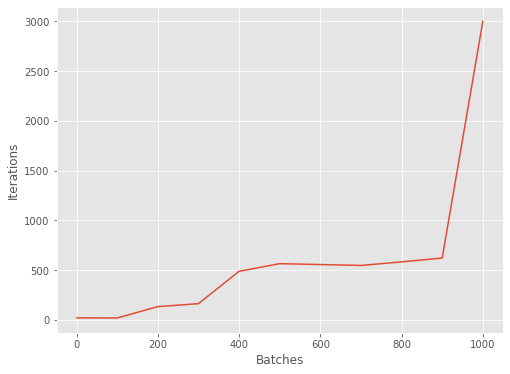

In [29]:
plt.figure(figsize=(8, 6))
plt.xlabel('Batches')
plt.ylabel('Iterations')
plt.plot(batches, iters)

Same issue happens with the computational time, as $b$ increases the spent time is larger.

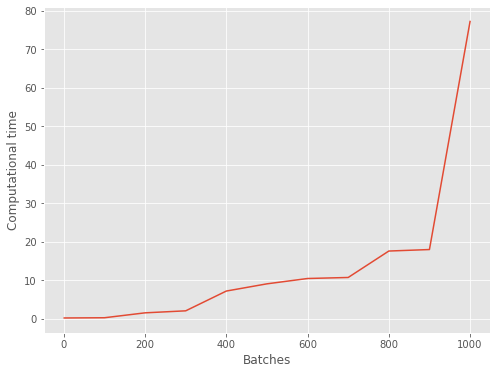

In [30]:
plt.figure(figsize=(8, 6))
plt.xlabel('Batches')
plt.ylabel('Computational time')
plt.plot(batches, times)

But if the error evolution is studied, it can be seen that this one is also decreased exponentially if a larger batch is used.

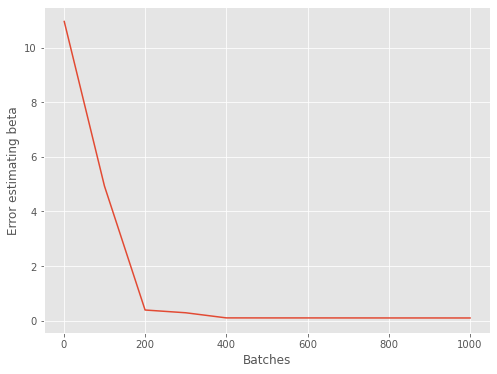

In [31]:
plt.figure(figsize=(8, 6))
plt.xlabel('Batches')
plt.ylabel('Error estimating beta')
plt.plot(batches, errors)

For these reason, it is advisable to find the balance according to the problem. In this case, as it is shown in the last picture and in the previous running results, a batch size of **400** performs very well in terms of error and computational time.

In [32]:
err = mini_batch_gradient_method(400, n_iter, epsilon, sigma, delta, alpha_init, ks=0)

------------------------------------------------------------------------------------------
| Algorithm           | Error      | Tolerance    | Iterations | Time (sec) | Sec/iter   |
------------------------------------------------------------------------------------------
| Mini-batch          | 0.10513    | 0.0          | 421        | 6.31816    | 0.01501    |
------------------------------------------------------------------------------------------


### D.3. Mini-batch gradient with momentum

It is the same algorithm than Mini-batch with an additional term in the computation of the regression coefficients. In each iteration is added a term called **momentum** which helps to reach faster the solution:

$$
\beta_{t+1} = \beta_t - \alpha \nabla f(\left.\beta^{*} \right) + \underbrace{\lambda (\beta_t - \beta_{t-1})}_\text{momentum}
$$

In [33]:
def mini_batch_momentum_gradient_method(batch=50, momentum=0.5, n_iter=2000, epsilon=1e-4, sigma=1e-5, delta=0.01, alpha_init=1e-5, ks = 5):
    '''Implement Mini-batch gradient method with momentum
    
    '''
    # Init algorithm dic
    alg = 'Mini-batch momentum'
    alg_dic[alg] = {}
    
    (a,b) = X.shape
    
    # Initial values for the variables and data containers
    beta = np.zeros(b) 
    OF_iter = np.zeros(n_iter)
    tol_iter = np.zeros(n_iter)
    alpha_iter = np.zeros(n_iter)
    
    # Time start
    time_start = time.process_time()
    
    # Mini batch with momentum method
    i = 0
    tol = 10000
    # iteration lower than maximum number and tolerance filter
    while (i <= n_iter-2) and (tol > epsilon):
        i = i + 1
        
        # get subsample data
        X_b, y_b = sample_data(batch)
        
        # compute gradient
        grad = ridge_reg_der(beta, X_b, y_b)
        # compute descent direction
        ddirect = -grad 
        
        # Armijo rule to adjust alph: now alpha is calculated with delta
        alpha = alpha_init
        while (ridge_reg(beta+alpha*ddirect,X,y) > ridge_reg(beta,X,y) + alpha*sigma*np.dot(ddirect,grad)):
            alpha = alpha*delta
        
        # compute new point
        beta_old = beta
        beta = beta + alpha*ddirect + momentum*(beta - beta_old)
    
        # objective value per iteration
        OF_iter[i] = ridge_reg(beta, X, y)
        
        # if the norm of the gradient is small, we can stop
        tol = np.absolute(OF_iter[i] - OF_iter[i-1])
        tol_iter[i] = tol
        
        # alpha iteration due to Armijo rule
        alpha_iter[i] = alpha
    
        
    # Measure elapsed time
    time_elapsed = (time.process_time() - time_start)
    
    # The error compares the obtained solution to the optimal solution (analytical)
    err = np.linalg.norm(np.transpose(beta_exact)-beta,ord=2)/np.linalg.norm(beta,ord=2)
    
    # Save stats
    alg_dic[alg]['err'] = round(err, 5)               # error
    alg_dic[alg]['nit'] = i                           # number of iterations
    alg_dic[alg]['tol'] = round(tol, 9)               # reached tolerance
    alg_dic[alg]['time'] = round(time_elapsed, 5)     # computational time
    alg_dic[alg]['sec'] = round(time_elapsed/i, 5)    # seconds per iteration
    
    # Show stats
    show_alg_stats(alg)
    
    # Show beta
    if ks > 0:
        print_beta(beta, ks)

As it has been explained before, a batch of **400** performs well, so this is the value used in this section.

In [34]:
# Parameters for the algorithm
batch = 400
momentum = 0.5
n_iter = 3000
epsilon = 1e-8
sigma = 1e-1
delta = 1e-1
alpha_init = 1e-5

# Run algorithm
mini_batch_momentum_gradient_method(batch, momentum, n_iter, epsilon, sigma, delta, alpha_init)

------------------------------------------------------------------------------------------
| Algorithm           | Error      | Tolerance    | Iterations | Time (sec) | Sec/iter   |
------------------------------------------------------------------------------------------
| Mini-batch momentum | 0.10269    | 0.0          | 381        | 6.0768     | 0.01595    |
------------------------------------------------------------------------------------------
--------------------------------------------------
| Index      | Beta            | Optimal beta    |
--------------------------------------------------
| 10         | 2.90908         | 3.00503         |
--------------------------------------------------
| 4          | 0.1073          | -0.01799        |
--------------------------------------------------
| 82         | -1.07782        | -1.01327        |
--------------------------------------------------
| 6          | 1.86872         | 1.99519         |
-----------------------------------

The results from the methods can be easily printed with functon `show_alg_stats()` and indicating the desired algorithms.

In [35]:
show_alg_stats(['Coordinate', 'Mini-batch', 'Mini-batch momentum'])

------------------------------------------------------------------------------------------
| Algorithm           | Error      | Tolerance    | Iterations | Time (sec) | Sec/iter   |
------------------------------------------------------------------------------------------
| Coordinate          | 0.09603    | 7e-09        | 7341       | 27.42444   | 0.00374    |
------------------------------------------------------------------------------------------
| Mini-batch          | 0.10513    | 0.0          | 421        | 6.31816    | 0.01501    |
------------------------------------------------------------------------------------------
| Mini-batch momentum | 0.10269    | 0.0          | 381        | 6.0768     | 0.01595    |
------------------------------------------------------------------------------------------


The **Mini-batch algorithm** with and without **momentum** perform similar. Mention there are not many samples, so the techniques could not provide all the potential. In addition, the batch size of the method with momentum has not been chosen appopiately, a tuning process of this parameter could lead to better results than the base algorithm.

Both mini-batch approaches are significantly better than the **Coordinate** method in terms of iterations.

The statistics of all the methods can be printed with `show_alg_stats()`.

In [36]:
show_alg_stats()

------------------------------------------------------------------------------------------
| Algorithm           | Error      | Tolerance    | Iterations | Time (sec) | Sec/iter   |
------------------------------------------------------------------------------------------
| Gradient            | 0.09287    | 43.065986502 | 1999       | 10.77377   | 0.00539    |
------------------------------------------------------------------------------------------
| Newton              | 0.0        | 2.813e-06    | 499        | 27.89775   | 0.05591    |
------------------------------------------------------------------------------------------
| Quasi-Newton        | 0.0        | 0.334951676  | 999        | 9.06882    | 0.00908    |
------------------------------------------------------------------------------------------
| Coordinate          | 0.09603    | 7e-09        | 7341       | 27.42444   | 0.00374    |
------------------------------------------------------------------------------------------

The results can be compared from two perspectives, the estimation error and the computational resources. 

First algorithms provide a result more precise, but they take longer. In this problem, the difference in time is not significant, but it is necessary to mention than the algorithms implemented in section D are thought for problem with a huge amount of samples and variables. In these situations, the difference in the computational resources is critical.

## E. Constrained problem

The problem formulation is:

\begin{align*}
\underset{\beta}{\min} \quad & ||y - X\beta||_2^2 \\
\text{s.t.}& \quad \sum_{j=1}^K \beta_j = 1
\end{align*}

There are only equality constraints, so it is going to be solved using a **penalization algorithm**, through a sequence of unconstrained problems. The Gradient method is employed in each iteration:

\begin{align*}
    \underset{\beta}{\min} & \quad ||y - X\beta||_2^2 + \frac{\rho}{2} (\sum_{j=1}^K \beta_j - 1)^2
\end{align*}

where $\rho > 0$ is the penalization parameter. This value is increased in each iteration in order to obtain better solutions. The gradient in this case is:

\begin{align*}
    \nabla f(\left.\beta^{*} \right) = -2(y - X\beta)^T X + \rho (\sum_{j=1}^K \beta_j - 1) e
\end{align*}

In [37]:
# Objective function
def constrained(beta_r, X, y, rho):
    '''Implement constrained function
    
    '''
    beta_r = np.matrix(beta_r)
    z = y - np.dot(X, beta_r.T)
    return np.dot(z.T,z) + (rho/2)*(np.sum(beta_r)-1)**2

# Gradient
def constrained_der(beta_r, X, y, rho):
    '''Implement gradient of constrained function
    
    '''
    beta_r = np.matrix(beta_r)
    pp = -2*np.dot((y-np.dot(X,(beta_r).T)).T,X) + rho*(np.sum(beta_r) - 1)
    aa = np.squeeze(np.asarray(pp))
    return aa

The following function is used to print statistics of the problem. It shows:

* Reached **tolerance**: calculated with the norm of the gradient.
* Computational **time** in seconds.
* Number of **iterations**.
* **Time per iteration**, in seconds.

In [38]:
def show_constrained_stats(tol_pen, time_elapsed, iter_pen, sec_pen):
    '''Print results
    
    '''
    print('-'*53)
    print(f"| {'Tolerance':<10} | {'Time (sec)':<10} | {'Iterations':<10} | {'Sec/iter':<10} |")
    print('-'*53)
    print(f"| {tol_pen:<10} | {time_elapsed:<10} | {iter_pen:<10} | {sec_pen:<10} |")
    print('-'*53)

In [39]:
def constrained_problem(n_iter=2000, n_iter_pen=1000, epsilon=1e-4, epsilon_pen=1e-8, sigma=1e-5, delta=0.01, alpha_init=1e-5, eta=1.5, rho_init=1.5):
    '''Implement constrained problem
    
    '''
    (a,b) = X.shape
    
    # Initial values for the variables and data containers
    beta_iter = np.zeros((b, n_iter_pen))
    OF_iter = np.zeros(n_iter)
    tol_iter = np.zeros(n_iter)
    alpha_iter = np.zeros(n_iter)

    # Time start
    time_start = time.process_time()
    
    # Unconstrained problem iterations
    t=0
    tol_pen = 10000
    while (t <= n_iter_pen-2) and (tol_pen>epsilon_pen):
        t=t+1
        if t==1:
            beta = np.zeros(b)
            rho = rho_init
        else:
            beta = beta_iter[:, t-1]
        
        # Gradient method
        i=0
        tol = 10000
        while (i <= n_iter-2) and (tol>epsilon):
            i=i+1
            # compute gradient
            grad = constrained_der(beta, X, y, rho)
            # compute descent direction
            ddirect = -grad
            
            # Armijo rule to adjust alph: now alpha is calculated with delta
            alpha = alpha_init
            while constrained(beta+alpha*ddirect, X, y, rho) > constrained(beta, X, y, rho) + alpha*sigma*np.dot(grad,ddirect.T):
                alpha=alpha*delta
                
            # compute new point
            beta = beta + alpha*ddirect
            tol=np.linalg.norm(grad, ord=2)
        
        beta_iter[:, t] = beta
        
        # update penalization term
        rho = rho*eta
        
        if t>1:
            # compare with the previous solution
            tol_pen=np.linalg.norm(beta_iter[:,t]-beta_iter[:,t-1],ord=2)
            
        
        
    # Measure elapsed time
    time_elapsed = (time.process_time() - time_start)
    
    # Show stats
    show_constrained_stats(round(tol_pen, 5), round(time_elapsed, 2), t, round(time_elapsed/i, 5))
    
    return beta_iter, t

In [40]:
# Parameters for the algorithm
n_iter = 1000         # maximum number of gradient iterations
n_iter_pen = 1000     # maximum number of penalization iterations
epsilon = 1e-8        # tolerance gradient limit
epsilon_pen = 1e-8    # tolerance penalization limit
sigma = 1e-2          # Armijo rule parameter
delta = 3e-1          # Armijo rule parameter
alpha_init = 3e-1     # initial alpha for Armijo rule
eta = 1.5             # penalization parameter
rho_init = 1          # initial rho

# Run algorithm
beta_iter, t = constrained_problem(n_iter, n_iter_pen, epsilon, epsilon_pen, sigma, delta, alpha_init, eta, rho_init)

-----------------------------------------------------
| Tolerance  | Time (sec) | Iterations | Sec/iter   |
-----------------------------------------------------
| 0.0        | 2273.0     | 54         | 2.27527    |
-----------------------------------------------------


In order to see if the algorithm is working, we can check if the constraint is satisfied as the number of iterations increases. If $\sum_{j=1}^K \beta_j = 1$, the logarithmic of the sum of $\beta$ should converge to zero. It means the unconstrained situation is becoming more constrained, what is the objective of this problem.

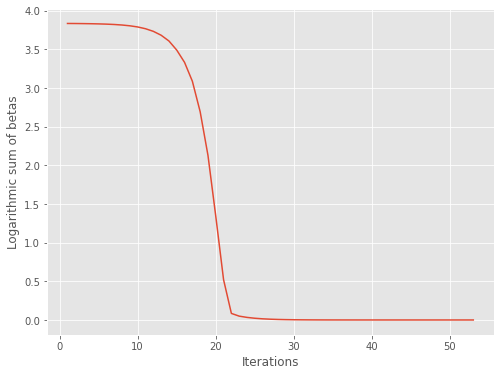

In [41]:
%%capture --no-display
plt.figure(figsize=(8, 6))
plt.xlabel('Iterations')
plt.ylabel('Logarithmic sum of betas')
plt.plot(np.log(np.sum(beta_iter, axis=0)[0:t]));

As it can be seen in the previous plot, the method is working properly. In next cell it is shown how the values of $\beta$ change until the tolerance limit is reached.

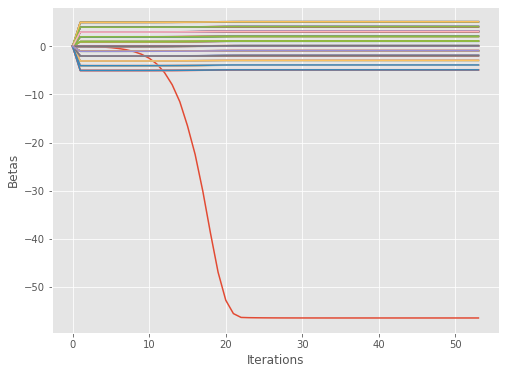

In [42]:
plt.figure(figsize=(8, 6))
plt.xlabel('Iterations')
plt.ylabel('Betas')
plt.plot(beta_iter[:, 0:t].T);

Most of the regression coefficients change in the first iterations and then remain constant. There is one which is slightly modified at the beginning and then exponentially until one point where it also does not change.